In [1]:
using Pkg
Pkg.activate("..")
Pkg.instantiate() # Usually only need to run this once
using JPEC, Plots, Printf
gr()

  Activating project at `c:\Users\thlmi\OneDrive\바탕 화면\서울대\대학원\codes\JPEC\JPEC-github0708\JPEC`


Plots.GRBackend()

In [2]:

#=
======================================================================
1. VALIDATION FOR 1D CUBIC SPLINE (Real)
======================================================================
=#
println("\n--- Testing 1D Spline Derivatives and Integration ---")

# --- 1.1 Data Generation ---
# Using 20 nodes to create a periodic spline for sin(x) and cos(x)
xs_nodes = collect(range(0.0, stop=2*pi, length=20))
y1_nodes = sin.(xs_nodes)
y2_nodes = cos.(xs_nodes)
fs_nodes_matrix = hcat(y1_nodes, y2_nodes)

# --- 1.2 Spline Setup (bctype=3 for periodic)---
spline_real = JPEC.SplinesMod.spline_setup(xs_nodes, fs_nodes_matrix; bctype=3)



--- Testing 1D Spline Derivatives and Integration ---


JPEC.SplinesMod.CubicSpline.RealSplineType(Ptr{Nothing} @0x000001cbfea653d0, [0.0, 0.3306939635357677, 0.6613879270715354, 0.9920818906073031, 1.3227758541430708, 1.6534698176788385, 1.9841637812146062, 2.3148577447503738, 2.6455517082861415, 2.9762456718219092, 3.306939635357677, 3.6376335988934447, 3.9683275624292125, 4.29902152596498, 4.6297154895007475, 4.960409453036515, 5.291103416572283, 5.621797380108051, 5.9524913436438185, 6.283185307179586], [0.0 1.0; 0.32469946920468346 0.9458172417006346; … ; -0.32469946920468373 0.9458172417006346; -2.4492935982947064e-16 1.0], 19, 2, 3, Matrix{Float64}(undef, 0, 0), [1.0034499202397256 0.008236256726111169; 0.9448111385955537 -0.32688451171607846; … ; 0.9448111385955528 0.32688451171610555; 1.003449920239726 -0.00823625672621131])

In [3]:

# --- 1.3 Evaluation on a Fine Grid ---
xs_fine = collect(range(0.0, stop=2*pi, length=200))


# Evaluate the spline and its derivatives up to the 3rd order
f_s, f1_s, f2_s, f3_s = JPEC.SplinesMod.spline_eval(spline_real, xs_fine, 3)


# --- 1.4 Perform Integration ---
# This modifies the spline_real object in-place, adding the .fsi field
JPEC.SplinesMod.spline_integrate!(spline_real)

# The result of integration is stored at the original node points.
# spline_real.fsi now contains the cumulative integral values.
integral_s = spline_real.fsi

# --- 1.5 Analytical (True) Values ---
# True values for the function and its derivatives on the fine grid
true_f  = hcat(sin.(xs_fine),  cos.(xs_fine))
true_f1 = hcat(cos.(xs_fine), -sin.(xs_fine))
true_f2 = hcat(-sin.(xs_fine), -cos.(xs_fine))
true_f3 = hcat(-cos.(xs_fine),  sin.(xs_fine))

# True values for the integral on the original coarse grid (xs_nodes)
# Integral of sin(x) from 0 to t is -cos(t) - (-cos(0)) = 1 - cos(t)
# Integral of cos(x) from 0 to t is sin(t) - sin(0) = sin(t)
true_integral = hcat(1.0 .- cos.(xs_nodes), sin.(xs_nodes))

print("evaluation complete")


evaluation complete

--- Generating 1D Spline Validation Plots ---
--- Generating 1D Spline Validation Plots ---

All 1D validation plots generated.


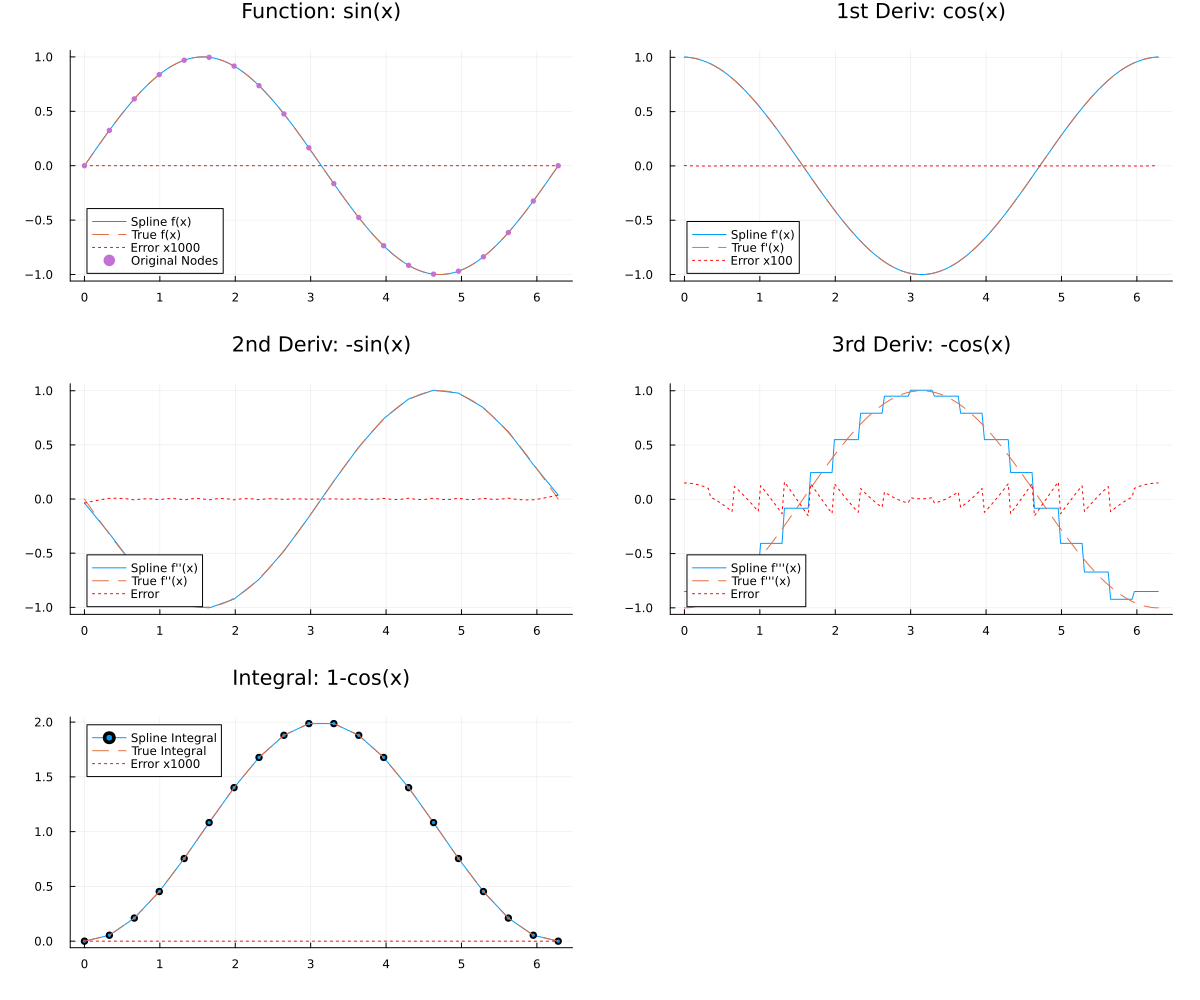

In [4]:

# --- 1.6 Plotting (Focusing on the first function, sin(x)) ---

# Plot for Function Value f(x)
function generate_spline_plot(
    x_vals, 
    spline_data, 
    analytic_data;
    title, 
    spline_label, 
    analytic_label,
    error_scale=1.0,
    legend_pos=:best,
    x_nodes=nothing,
    y_nodes=nothing,
    nodes_label="Original Nodes",
    kwargs...
)
    
    p = plot(x_vals, spline_data, label=spline_label, title=title, legend=legend_pos; kwargs...)
    
    plot!(p, x_vals, analytic_data, ls=:dash, label=analytic_label)
    scaler_str = isinteger(error_scale) ? string(Int(error_scale)) : string(error_scale)
    error_label = error_scale == 1.0 ? "Error" : "Error x" * scaler_str
    plot!(p, x_vals, spline_data .- analytic_data, ls=:dot, label=error_label, color=:red)
    
    if x_nodes !== nothing && y_nodes !== nothing
        scatter!(p, x_nodes, y_nodes, label=nodes_label, markersize=3, markerstrokewidth=0)
    end
    
    return p
end

# --- 1.6 Generate and Display all plots ---

println("--- Generating 1D Spline Validation Plots ---")

plot_configs_real = [
    # f(x) 
    (
        spline_data = f_s[:, 1],      analytic_data = true_f[:, 1],      x_vals = xs_fine,
        title = "Function: sin(x)",   spline_label = "Spline f(x)",      analytic_label = "True f(x)",
        error_scale = 1000.0,         legend_pos = :bottomleft,
        x_nodes = xs_nodes,           y_nodes = y1_nodes
    ),
    # f'(x) 
    (
        spline_data = f1_s[:, 1],     analytic_data = true_f1[:, 1],     x_vals = xs_fine,
        title = "1st Deriv: cos(x)",  spline_label = "Spline f'(x)",     analytic_label = "True f'(x)",
        error_scale = 100.0,          legend_pos = :bottomleft
    ),
    # f''(x)
    (
        spline_data = f2_s[:, 1],     analytic_data = true_f2[:, 1],     x_vals = xs_fine,
        title = "2nd Deriv: -sin(x)", spline_label = "Spline f''(x)",    analytic_label = "True f''(x)",
        error_scale = 1.0,            legend_pos = :bottomleft
    ),
    # f'''(x)
    (
        spline_data = f3_s[:, 1],     analytic_data = true_f3[:, 1],     x_vals = xs_fine,
        title = "3rd Deriv: -cos(x)", spline_label = "Spline f'''(x)",   analytic_label = "True f'''(x)",
        error_scale = 1.0,            legend_pos = :bottomleft
    ),
    # integral 
    (
        spline_data = integral_s[:, 1], analytic_data = true_integral[:, 1], x_vals = xs_nodes,
        title = "Integral: 1-cos(x)",   spline_label = "Spline Integral",  analytic_label = "True Integral",
        error_scale = 1000.0,           legend_pos = :topleft,
        style = (markershape=:circle, markersize=3)
    )
]


plot_list_real = []
println("--- Generating 1D Spline Validation Plots ---")

for config in plot_configs_real
    
    p = generate_spline_plot(
        config.x_vals,
        config.spline_data,
        config.analytic_data;
        title = config.title,
        spline_label = config.spline_label,
        analytic_label = config.analytic_label,
        error_scale = config.error_scale,
        legend_pos = config.legend_pos,
        
        x_nodes = get(config, :x_nodes, nothing),
        y_nodes = get(config, :y_nodes, nothing),
        
        (haskey(config, :style) ? config.style : ())...
    )
    push!(plot_list_real, p)
end


display(plot(plot_list_real..., layout=(3, 2), size=(1200, 1000), margin=5Plots.mm))



println("\nAll 1D validation plots generated.")

In [5]:

#=
======================================================================
2. VALIDATION FOR 1D CUBIC SPLINE (Complex)
======================================================================
=#
println("\n--- Testing 1D Complex Spline Derivatives and Integration ---")

# --- 2.1 Data Generation ---
xs_nodes = collect(range(0.0, stop=2*pi, length=40))
fs_complex_nodes = exp.(im .* xs_nodes)

# --- 2.2 Spline Setup (bctype=3 for periodic) ---
spline_complex = JPEC.SplinesMod.spline_setup(xs_nodes, fs_complex_nodes; bctype = 3)



--- Testing 1D Complex Spline Derivatives and Integration ---


JPEC.SplinesMod.CubicSpline.ComplexSplineType(Ptr{Nothing} @0x000001cbf7775900, [0.0, 0.16110731556870733, 0.32221463113741466, 0.483321946706122, 0.6444292622748293, 0.8055365778435367, 0.966643893412244, 1.1277512089809514, 1.2888585245496587, 1.4499658401183662  …  4.8332194670612205, 4.994326782629927, 5.155434098198635, 5.316541413767342, 5.47764872933605, 5.638756044904757, 5.799863360473465, 5.960970676042171, 6.122077991610879, 6.283185307179586], ComplexF64[1.0 + 0.0im; 0.9870502626379128 + 0.16041128085776024im; … ; 0.9870502626379128 - 0.16041128085776063im; 1.0 - 2.4492935982947064e-16im;;], 39, 1, 3, Matrix{ComplexF64}(undef, 0, 0), ComplexF64[0.0010229219584163562 + 1.00020024116745im; -0.1606847697363273 + 0.9869918965183956im; … ; 0.16068476973604057 + 0.9869918965183956im; -0.0010229219573456572 + 1.0002002411674495im;;])

In [6]:

# --- 2.3 Evaluation on a Fine Grid ---
xs_fine = collect(range(0.0, stop=2*pi, length=200))
f_cs, f1_cs, f2_cs, f3_cs = JPEC.SplinesMod.spline_eval(spline_complex, xs_fine, 3)

# --- 2.4 Perform Integration ---
# This modifies the spline_complex object in-place, adding the .fsi field
JPEC.SplinesMod.spline_integrate!(spline_complex)
integral_cs = spline_complex.fsi

# --- 2.5 Analytical (True) Values ---
true_f_c  = exp.(im .* xs_fine)
true_f1_c = im .* exp.(im .* xs_fine)
true_f2_c = -1 .* exp.(im .* xs_fine)
true_f3_c = -im .* exp.(im .* xs_fine)

# True values for the integral on the original node grid
# Integral of exp(ix) from 0 to t is i*(1 - exp(ix))
true_integral_c = im .* (1.0 .- exp.(im .* xs_nodes))

print("evaluation complete")

evaluation complete

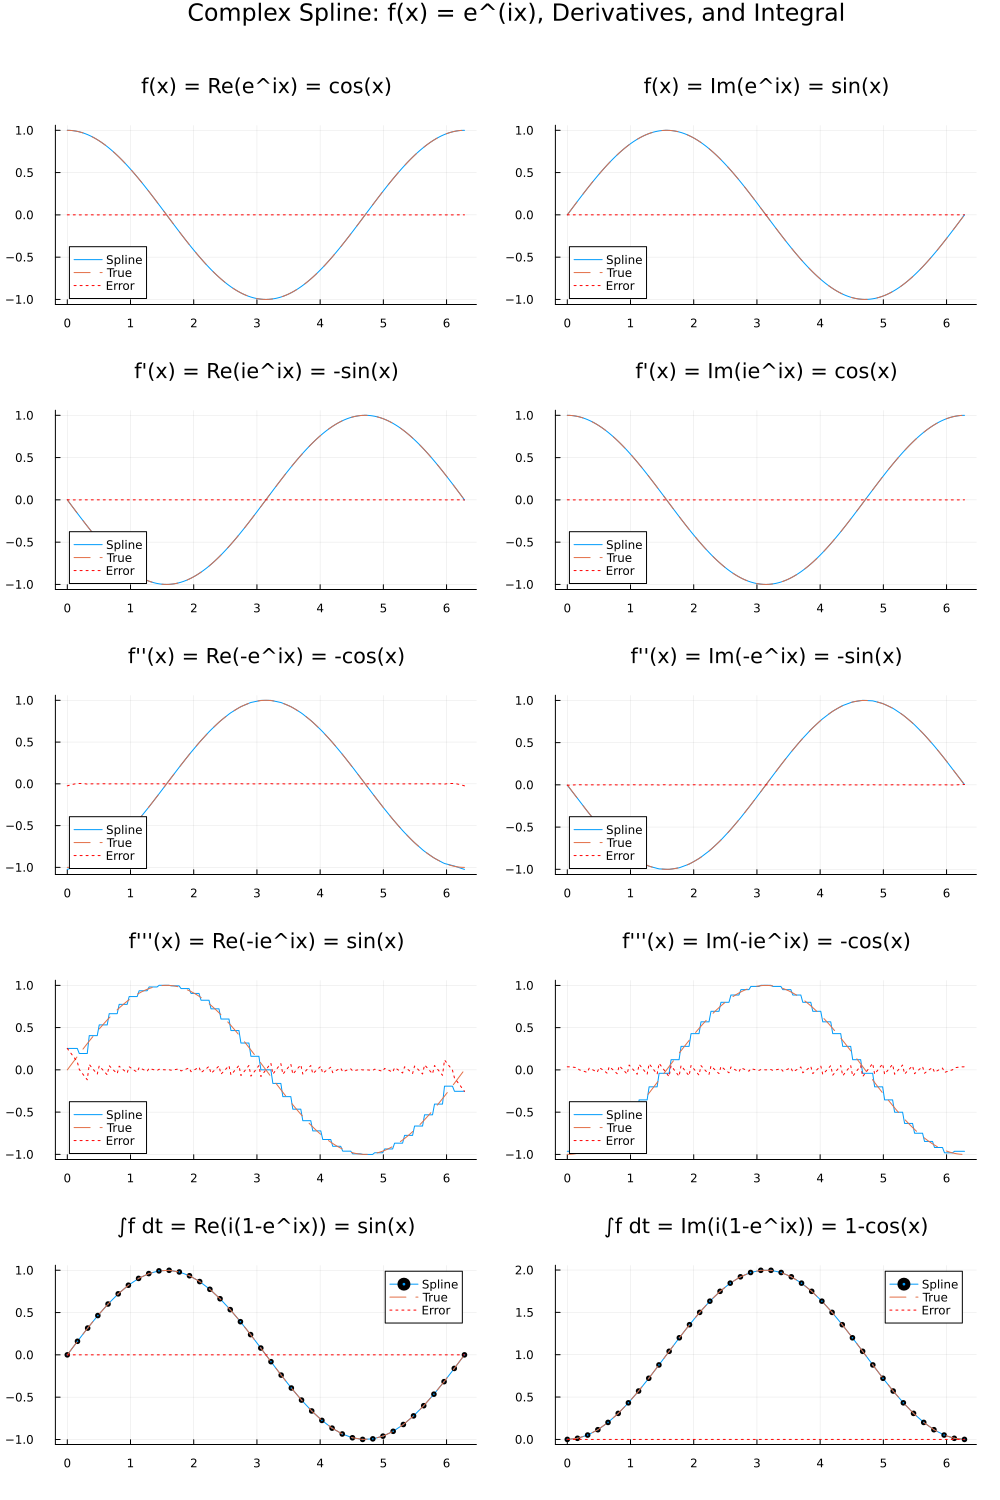

--- Generating Complex Spline Validation Plots ---

All complex validation plots generated.


In [7]:

# --- 2.6 Plotting ---
function generate_complex_spline_plot(
     x_vals, 
     spline_c, 
     analytic_c; 
     part, 
     title, 
     kwargs...
 )
     func = (part == :real) ? real : imag
     
     spline_data = func(spline_c)
     analytic_data = func(analytic_c)
     
     p = plot(x_vals, spline_data, label="Spline", title=title; kwargs...)
     
     plot!(p, x_vals, analytic_data, ls=:dash, label="True")
     plot!(p, x_vals, spline_data .- analytic_data, ls=:dot, label="Error", color=:red)
     
     return p
end



plot_configs = [
    (label="f(x)",   data_s=f_cs,   data_t=true_f_c,   formula="e^ix",      re_res="cos(x)",   im_res="sin(x)",   x_vals=xs_fine),
    (label="f'(x)",  data_s=f1_cs,  data_t=true_f1_c,  formula="ie^ix",     re_res="-sin(x)",  im_res="cos(x)",   x_vals=xs_fine),
    (label="f''(x)", data_s=f2_cs,  data_t=true_f2_c,  formula="-e^ix",     re_res="-cos(x)",  im_res="-sin(x)",  x_vals=xs_fine),
    (label="f'''(x)",data_s=f3_cs,  data_t=true_f3_c,  formula="-ie^ix",    re_res="sin(x)",   im_res="-cos(x)",  x_vals=xs_fine),
    (label="∫f dt",  data_s=integral_cs, data_t=true_integral_c, formula="i(1-e^ix)", re_res="sin(x)", im_res="1-cos(x)", x_vals=xs_nodes, style=(markershape=:circle, markersize=2)),
]

plot_list = []
println("--- Generating Complex Spline Validation Plots ---")


for config in plot_configs
    for part_info in ((part=:real, name="Re", res=config.re_res), 
                      (part=:imag, name="Im", res=config.im_res))
        
        title = "$(config.label) = $(part_info.name)($(config.formula)) = $(part_info.res)"
        
        plot_style = haskey(config, :style) ? config.style : (legend=:bottomleft,)

        p = generate_complex_spline_plot(
            config.x_vals, 
            config.data_s, 
            config.data_t;
            part=part_info.part,
            title=title,
            plot_style... 
        )
        push!(plot_list, p)
    end
end

display(plot(plot_list..., layout=(5, 2), size=(1000, 1500),
             plot_title="Complex Spline: f(x) = e^(ix), Derivatives, and Integral",
             margin=4Plots.mm))

println("\nAll complex validation plots generated.")

In [8]:
#=
======================================================================
3. VALIDATION FOR 2D BICUBIC SPLINE
======================================================================
=#
println("\n--- Testing 2D Bicubic Spline Derivatives ---")

# --- 3.1 Data Generation (for fitting) ---
nx_nodes, ny_nodes = 20, 20
x_nodes = collect(range(0.0, stop=2*pi, length=nx_nodes))
y_nodes = collect(range(0.0, stop=2*pi, length=ny_nodes))

f_nodes = zeros(nx_nodes, ny_nodes, 1) # n_qty = 1 for this test
for j in 1:ny_nodes, i in 1:nx_nodes
    f_nodes[i, j, 1] = sin(x_nodes[i]) * cos(y_nodes[j])
end

# --- 3.2 Spline Setup (bctype=2 for periodic in both dimensions) ---
bcspline = JPEC.SplinesMod.bicube_setup(x_nodes, y_nodes, f_nodes, bctypex=2,bctypey= 2)



--- Testing 2D Bicubic Spline Derivatives ---


JPEC.SplinesMod.BicubicSpline.BicubicSplineType(Ptr{Nothing} @0x000001cc0019f6e0, [0.0, 0.3306939635357677, 0.6613879270715354, 0.9920818906073031, 1.3227758541430708, 1.6534698176788385, 1.9841637812146062, 2.3148577447503738, 2.6455517082861415, 2.9762456718219092, 3.306939635357677, 3.6376335988934447, 3.9683275624292125, 4.29902152596498, 4.6297154895007475, 4.960409453036515, 5.291103416572283, 5.621797380108051, 5.9524913436438185, 6.283185307179586], [0.0, 0.3306939635357677, 0.6613879270715354, 0.9920818906073031, 1.3227758541430708, 1.6534698176788385, 1.9841637812146062, 2.3148577447503738, 2.6455517082861415, 2.9762456718219092, 3.306939635357677, 3.6376335988934447, 3.9683275624292125, 4.29902152596498, 4.6297154895007475, 4.960409453036515, 5.291103416572283, 5.621797380108051, 5.9524913436438185, 6.283185307179586], [0.0 0.0 … 0.0 0.0; 0.32469946920468346 0.30710635634483385 … 0.30710635634483385 0.32469946920468346; … ; -0.32469946920468373 -0.30710635634483413 … -0.3071

In [9]:

# --- 3.3 Evaluation ---
nx_fine, ny_fine = 50, 50
x_fine = collect(range(0.0, stop=2*pi, length=nx_fine))
y_fine = collect(range(0.0, stop=2*pi, length=ny_fine))

# Get derivatives up to 2nd order
f_s, fx_s, fy_s, fxx_s, fxy_s, fyy_s = JPEC.SplinesMod.bicube_eval(bcspline, x_fine, y_fine, 2)


# --- 3.4 Analytical (True) Functions ---
f_analytic(x, y)   = sin(x) * cos(y)
fx_analytic(x, y)  = cos(x) * cos(y)
fy_analytic(x, y)  = -sin(x) * sin(y)
fxx_analytic(x, y) = -sin(x) * cos(y)
fyy_analytic(x, y) = -sin(x) * cos(y)
fxy_analytic(x, y) = -cos(x) * sin(y)



fxy_analytic (generic function with 1 method)

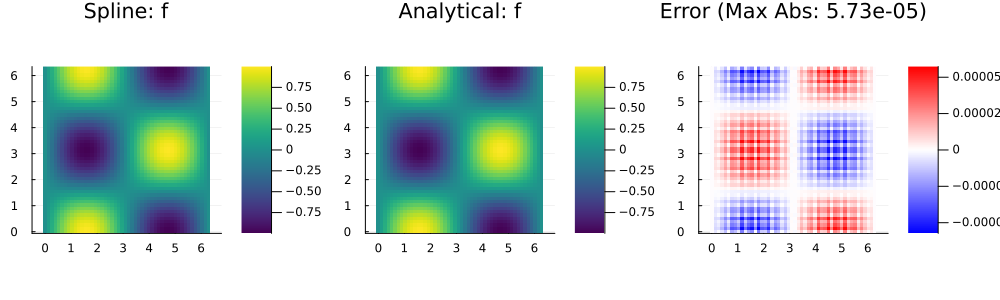

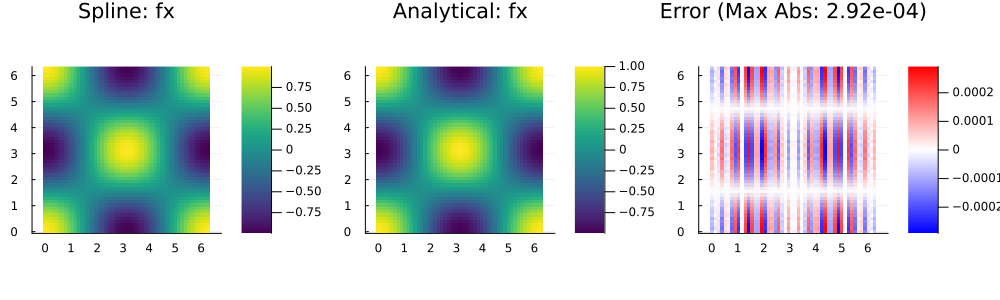

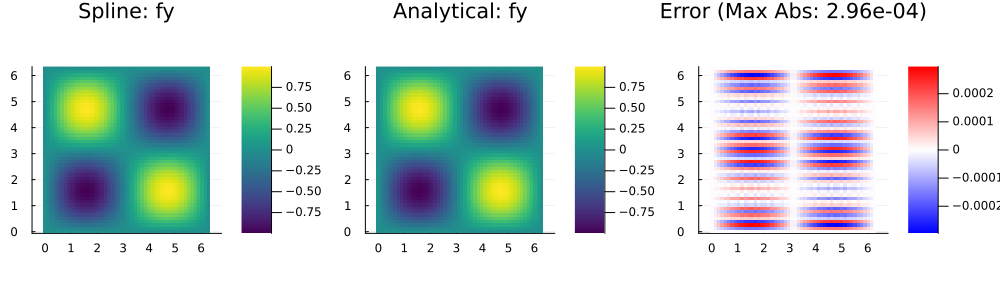

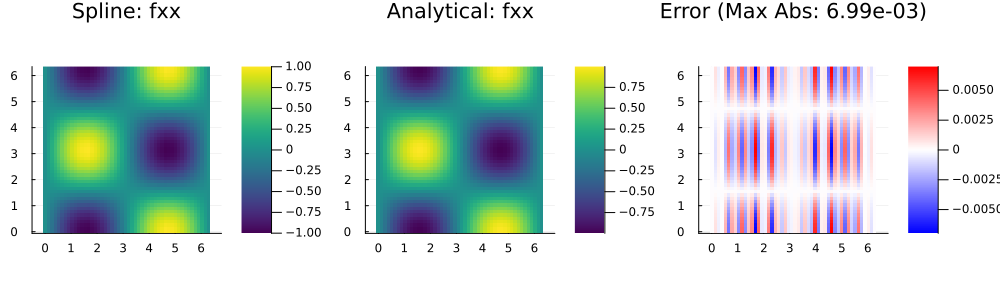

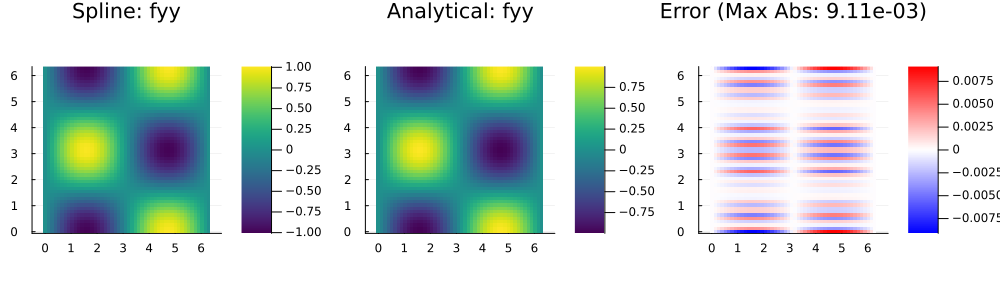

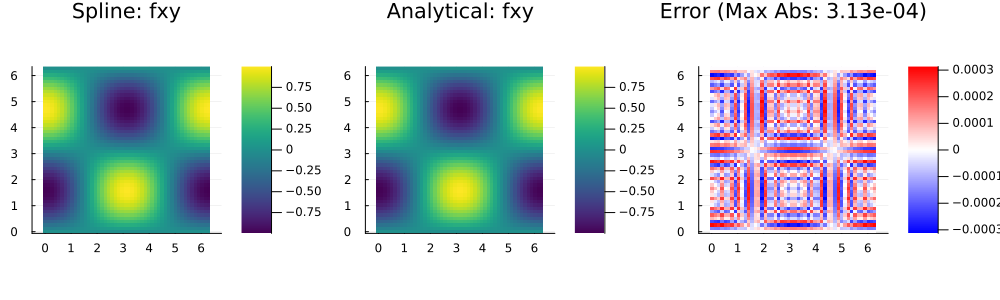

In [10]:
# --- 3.5 Plotting Helper Function ---
function generate_bicube_plots(name, spline_data, analytic_func, x_grid, y_grid)
    
    analytical_data = [analytic_func(x, y) for x in x_grid, y in y_grid]
    spline_slice = spline_data[:, :, 1]
    error_data = spline_slice - analytical_data
    max_abs_error = maximum(abs, error_data)
    
    p1 = heatmap(x_grid, y_grid, spline_slice', title="Spline: $name", c=:viridis)
    p2 = heatmap(x_grid, y_grid, analytical_data', title="Analytical: $name", c=:viridis)
    p3 = heatmap(x_grid, y_grid, error_data', title="Error (Max Abs: $(@sprintf("%.2e", max_abs_error)))", c=:bwr)

    return plot(p1, p2, p3, layout=(1, 3), size=(1000, 300), aspect_ratio=:equal)
end

# --- 3.6 Generate and Display all plots ---
display(generate_bicube_plots("f",   f_s,   f_analytic,   x_fine, y_fine))
display(generate_bicube_plots("fx",  fx_s,  fx_analytic,  x_fine, y_fine))
display(generate_bicube_plots("fy",  fy_s,  fy_analytic,  x_fine, y_fine))
display(generate_bicube_plots("fxx", fxx_s, fxx_analytic, x_fine, y_fine)) 
display(generate_bicube_plots("fyy", fyy_s, fyy_analytic, x_fine, y_fine)) 
display(generate_bicube_plots("fxy", fxy_s, fxy_analytic, x_fine, y_fine))



In [11]:
#=
======================================================================
4. VALIDATION FOR 2D FOURIER SPLINE (CUBIC-X, FOURIER-Y)
======================================================================
=#
# Assuming JPEC.SplinesMod.FourierSpline is where the module is located
# For standalone testing, you might need:
# include("FourierSpline.jl")
# using .FourierSpline

println("\n--- Testing 2D Fourier-Spline Derivatives ---")



# --- 4.1 Data Generation (for fitting) ---
# For fit_method=2 (FFT), my_nodes must be a power of 2.
# We use mx+1 points for x and my+1 points for y.
# The grid is [0, mx] and [0, my].
mx_nodes, my_nodes = 32, 32 # my_nodes must be a power of 2 for FFT test
x_nodes = collect(range(0.0, stop=3.0, length=mx_nodes + 1))
# y is periodic from 0 to 2pi. The last point y_nodes[my+1] should equal the first y_nodes[1] + 2pi
y_nodes = collect(range(0.0, stop=2*pi, length=my_nodes + 1))

f_nodes = zeros(mx_nodes + 1, my_nodes + 1, 1) # n_qty = 1
for j in 1:(my_nodes + 1), i in 1:(mx_nodes + 1)
    f_nodes[i, j, 1] = f_analytic(x_nodes[i], y_nodes[j])
end

# --- 4.2 Spline Setup ---
# Use bctype=1 (natural) for x-direction as it's not periodic.
# The y-direction is inherently periodic.
# mband determines how many Fourier modes are used. A higher number gives more accuracy.
mband_val = 10 

# Test both fit methods
println("\n--- Setting up with fit_method=1 (Integral) ---")
fspline_m1 = JPEC.SplinesMod.fspline_setup(x_nodes, y_nodes, f_nodes, mband_val, bctype=4, fit_method=1,fit_flag=true)

println("\n--- Setting up with fit_method=2 (FFT) ---")
# This requires my_nodes to be a power of 2.
fspline_m2 = JPEC.SplinesMod.fspline_setup(x_nodes, y_nodes, f_nodes, mband_val, bctype=2, fit_method=2,fit_flag=true)



--- Testing 2D Fourier-Spline Derivatives ---

--- Setting up with fit_method=1 (Integral) ---

--- Setting up with fit_method=2 (FFT) ---


JPEC.SplinesMod.FourierSpline.FourierSplineType(Ptr{Nothing} @0x000001cbf7793350, [0.0, 0.19634954084936207, 0.39269908169872414, 0.5890486225480862, 0.7853981633974483, 0.9817477042468103, 1.1780972450961724, 1.3744467859455345, 1.5707963267948966, 1.7671458676442586  …  4.516039439535327, 4.71238898038469, 4.908738521234052, 5.105088062083414, 5.301437602932776, 5.497787143782138, 5.6941366846315, 5.890486225480862, 6.086835766330224, 6.283185307179586], Float64[], [0.0 0.0 … 0.0 0.0; 0.09361273123551289 0.09181398885413476 … 0.09181398885413475 0.09361273123551289; … ; 0.23317620736685893 0.22869579192566655 … 0.22869579192566653 0.23317620736685893; 0.1411200080598672 0.13840842667550302 … 0.138408426675503 0.1411200080598672;;;], 32, 32, 10, 1, 2, 2)

In [12]:

# --- 4.3 Evaluation ---
# We will evaluate using the FFT-fitted spline (method 2) as it's generally faster if applicable.
# You can switch to fspline_m1 to compare.
chosen_fspline = fspline_m1

nx_fine, ny_fine = 60, 60
x_fine = collect(range(0.0, stop=3.0, length=nx_fine))
y_fine = collect(range(0.0, stop=2*pi, length=ny_fine))

# Get derivatives up to 2nd order
f_s, fx_s, fy_s, fxx_s, fxy_s, fyy_s = JPEC.SplinesMod.fspline_eval(chosen_fspline, x_fine, y_fine, Int(2))


# --- 4.4 Analytical (True) Functions (Periodic in y) ---
f_analytic(x, y)   = x^2 * cos(2*y)
fx_analytic(x, y)  = 2*x * cos(2*y)
fy_analytic(x, y)  = -2 * x^2 * sin(2*y)
fxx_analytic(x, y) = 2 * cos(2*y)x
fyy_analytic(x, y) = -4 * x^2 * cos(2*y)
fxy_analytic(x, y) = -4 * x * sin(2*y)

print("evaluation complete")

evaluation complete

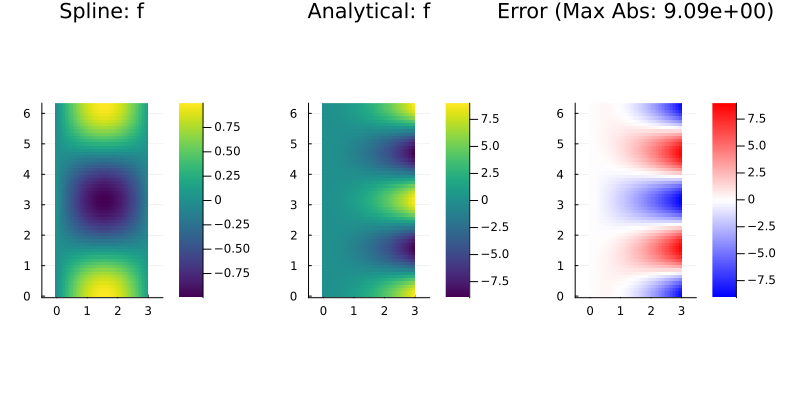

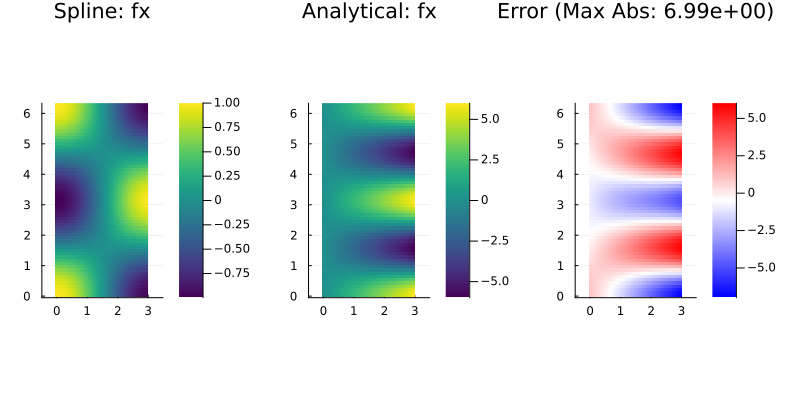

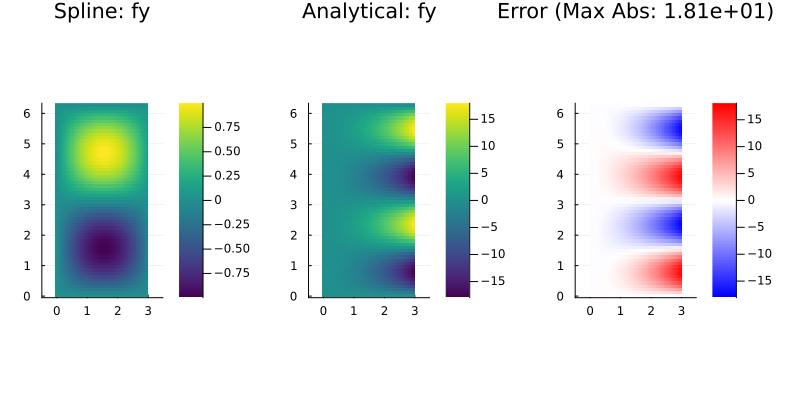

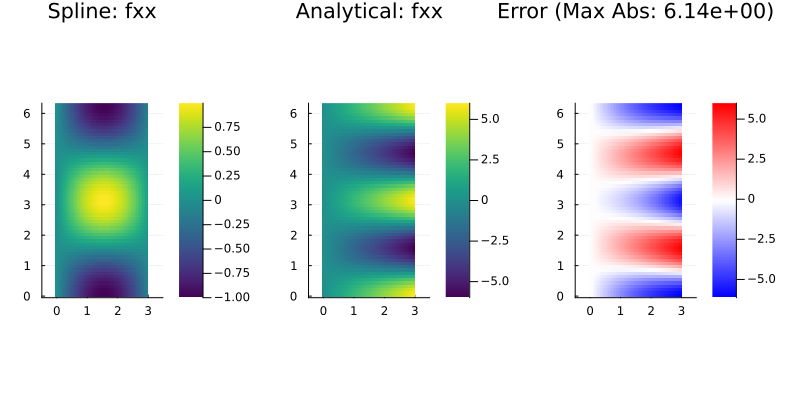

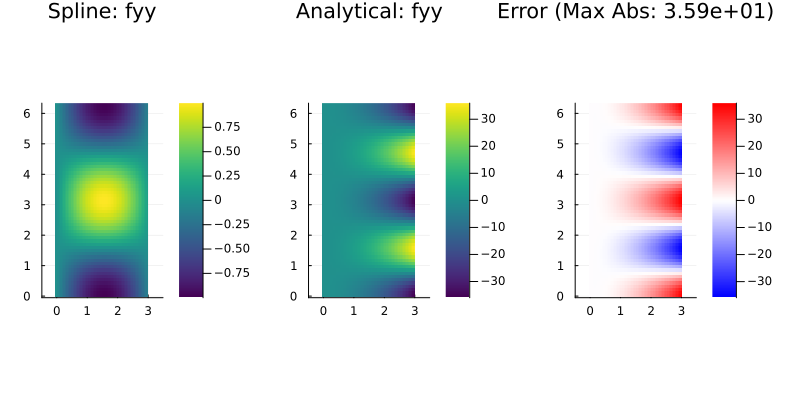

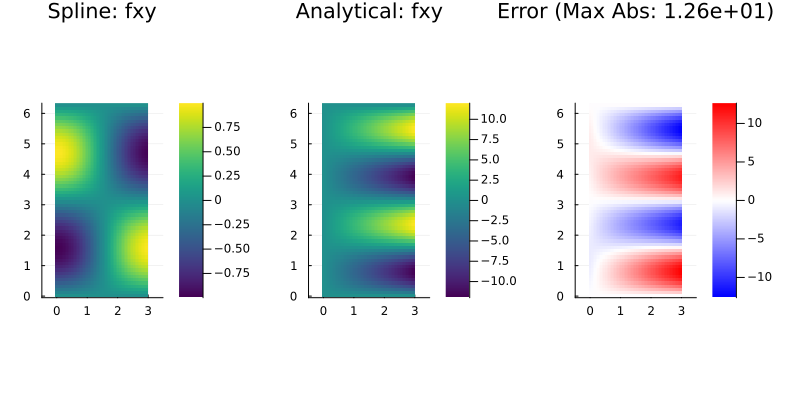


All Fourier Spline validation plots generated.


In [13]:
function generate_fspline_plot(name, spline_data, analytic_func, x_grid, y_grid)

    
    # 1. Generate the analytical data on the fine grid
    analytical_data = [analytic_func(x, y) for x in x_grid, y in y_grid]
    
    # 2. Extract the 2D slice from the 3D spline output array (n_qty=1)
    spline_slice = spline_data[:, :, 1]
    
    # 3. Calculate the error between the spline and analytical data
    error_data = spline_slice - analytical_data
    max_abs_error = maximum(abs, error_data)
    
    # 4. Create three separate heatmaps for comparison
    # Note: We transpose the data (') because Plots.jl heatmap expects (y, x) data layout
    p1 = heatmap(x_grid, y_grid, spline_slice', 
                 title="Spline: $name", c=:viridis, aspect_ratio=:equal)
                 
    p2 = heatmap(x_grid, y_grid, analytical_data', 
                 title="Analytical: $name", c=:viridis, aspect_ratio=:equal)
                 
    p3 = heatmap(x_grid, y_grid, error_data', 
                 title="Error (Max Abs: $(@sprintf("%.2e", max_abs_error)))", c=:bwr, aspect_ratio=:equal)

    # 5. Combine the three heatmaps into a single plot object with a 1x3 layout
    return plot(p1, p2, p3, layout=(1, 3), size=(800, 400), margin=4Plots.mm)
end


# --- 4.5 Generate all plots ---
# This section calls the helper function for the main function and each derivative,
# displaying each result as a separate row of plots.

display(generate_fspline_plot("f",   f_s,   f_analytic,   x_fine, y_fine))
display(generate_fspline_plot("fx",  fx_s,  fx_analytic,  x_fine, y_fine))
display(generate_fspline_plot("fy",  fy_s,  fy_analytic,  x_fine, y_fine))
display(generate_fspline_plot("fxx", fxx_s, fxx_analytic, x_fine, y_fine))
display(generate_fspline_plot("fyy", fyy_s, fyy_analytic, x_fine, y_fine))
display(generate_fspline_plot("fxy", fxy_s, fxy_analytic, x_fine, y_fine))

println("\nAll Fourier Spline validation plots generated.")